In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

# Overfitting vs underfitting

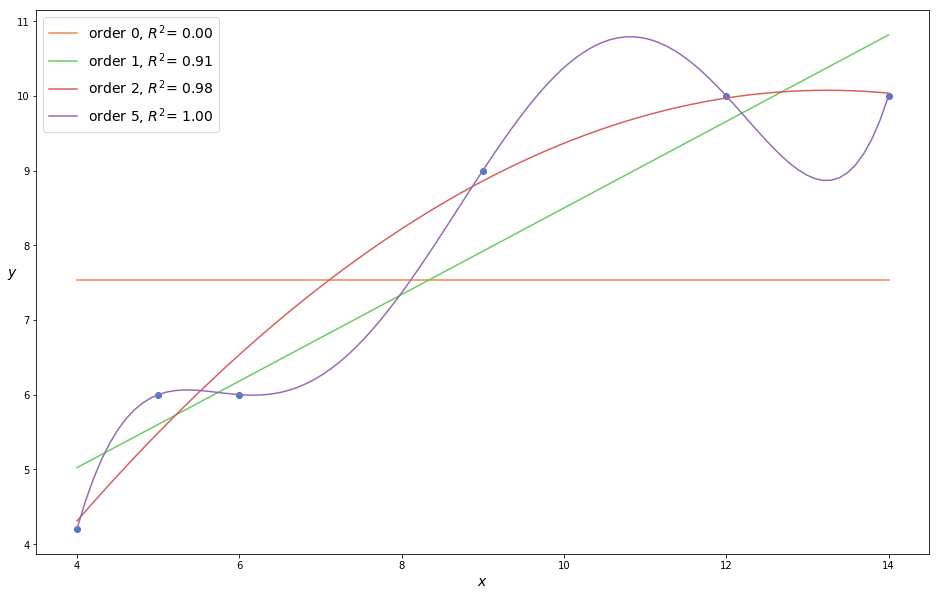

In [2]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))

plt.legend(loc=2, fontsize=14);
plt.xlabel('$x$', fontsize=14);
plt.ylabel('$y$', fontsize=14, rotation=0);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

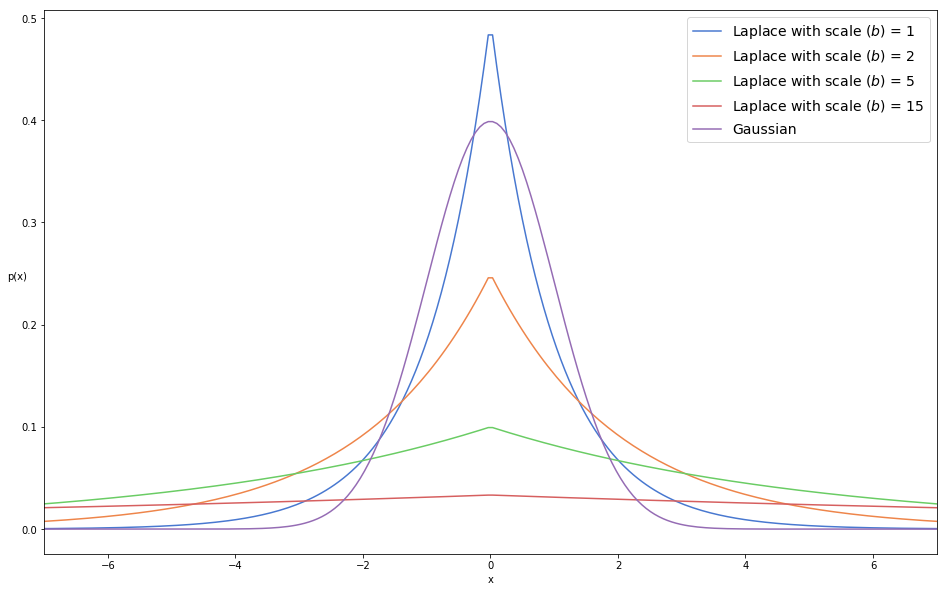

In [3]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 300)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='Laplace with scale ($b$) = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

In [4]:
x_1 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([  8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
        10.84,   4.82,   5.68])

In [5]:
np.random.seed(1)
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

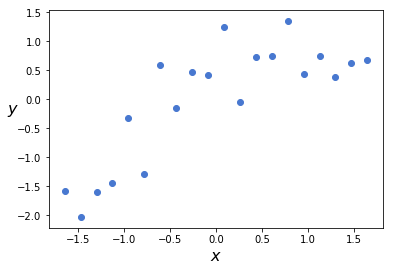

In [6]:
order = 2#5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()
plt.scatter(x_1s[0], y_1s);
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$y$', fontsize=16, rotation=0);

#### model_l: Not including polynomial term

In [7]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta * x_1s[0]
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_l = pm.sample(2100,chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 2600/2600 [00:02<00:00, 1189.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


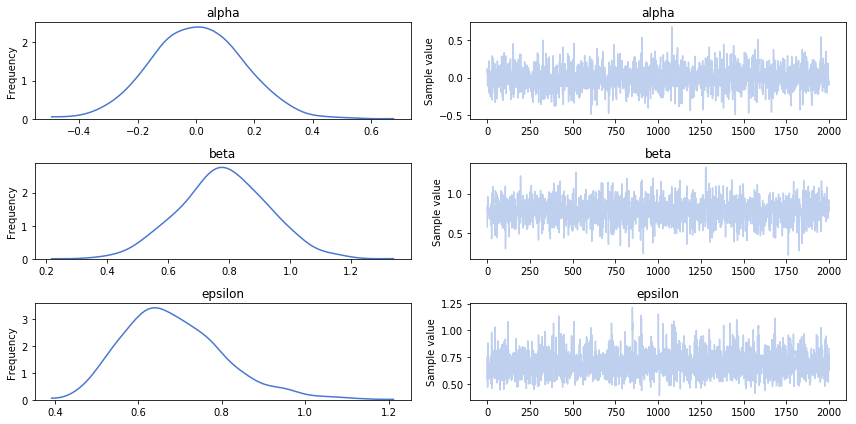

In [8]:
chain_l = trace_l[100:]
pm.traceplot(chain_l);

In [9]:
pm.summary(chain_l)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.002707,0.157234,0.004058,-0.297762,0.309386
beta,0.779145,0.148678,0.003046,0.482230,1.051304
epsilon,0.683799,0.120173,0.002663,0.459332,0.920043


#### model_p: Iincluding polynomial term

In [10]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])  
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, x_1s)
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_p = pm.sample(2100,chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 2600/2600 [00:04<00:00, 575.17it/s]
The acceptance probability does not match the target. It is 0.8964686391665999, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


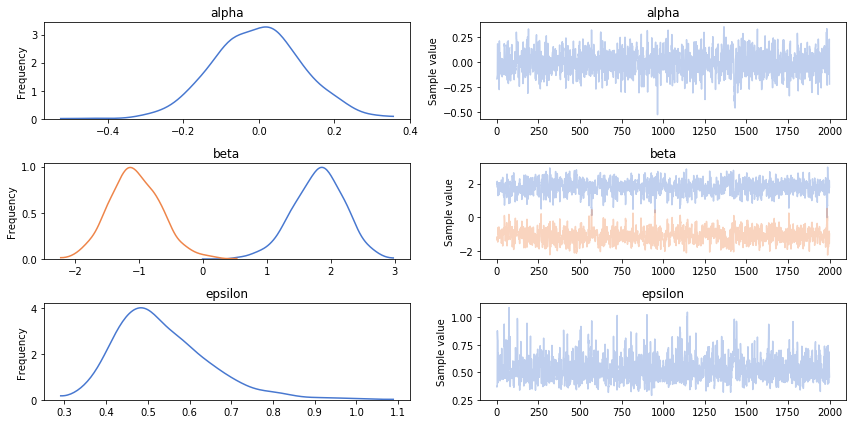

In [11]:
chain_p = trace_p[100:]
pm.traceplot(chain_p);

In [12]:
pm.summary(chain_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.006345,0.118836,0.003146,-0.220809,0.234278
beta__0,1.796237,0.404589,0.014456,0.996769,2.578225
beta__1,-1.061327,0.403376,0.014966,-1.888992,-0.312826
epsilon,0.535186,0.113336,0.003481,0.339629,0.762821


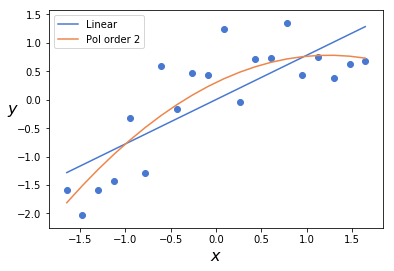

In [13]:
alpha_l_post = chain_l['alpha'].mean()
betas_l_post = chain_l['beta'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_l_post = alpha_l_post + betas_l_post * x_1s[0]

plt.plot(x_1s[0][idx], y_l_post[idx], label='Linear')


alpha_p_post = chain_p['alpha'].mean()
betas_p_post = chain_p['beta'].mean(axis=0)
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label='Pol order {}'.format(order))

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend();

# Information criteria

In [14]:
model_p.name='Polynomial'
model_l.name='Linear'
dic_l = pm.compare({model_p: trace_p, model_l: trace_l})
dic_l 

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Polynomial,32.67,2.64,0,1,4.61,0,0
Linear,42.5,2.14,9.83,0,4.16,2.71,0


In [15]:
waic_l = pm.waic(trace=trace_l, model=model_l)
waic_l

WAIC_r(WAIC=42.50361731898587, WAIC_se=4.157641613844861, p_WAIC=2.1412246201899223, var_warn=0)

In [16]:
waic_p = pm.waic(trace=trace_p, model=model_p)
waic_p

WAIC_r(WAIC=32.67190882656928, WAIC_se=4.610510226210436, p_WAIC=2.6390976063746674, var_warn=0)

In [17]:
loo_l = pm.loo(trace=trace_l, model=model_l)
loo_l

LOO_r(LOO=42.62390890178155, LOO_se=4.1873713733381175, p_LOO=2.2013704115877637, shape_warn=0)

In [18]:
loo_p = pm.loo(trace=trace_p, model=model_p)
loo_p

LOO_r(LOO=32.83617091380626, LOO_se=4.654341727757128, p_LOO=2.721228649993158, shape_warn=0)

### Lower is better

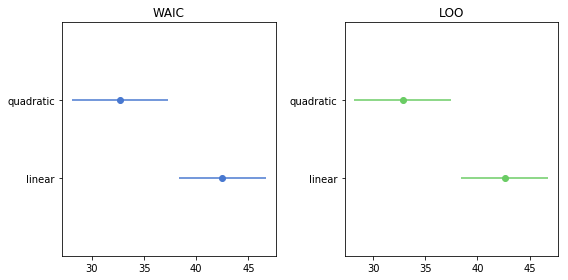

In [19]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
plt.title('WAIC')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.subplot(122)
for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='go')
plt.title('LOO')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.tight_layout()

## Posterior predictive checks

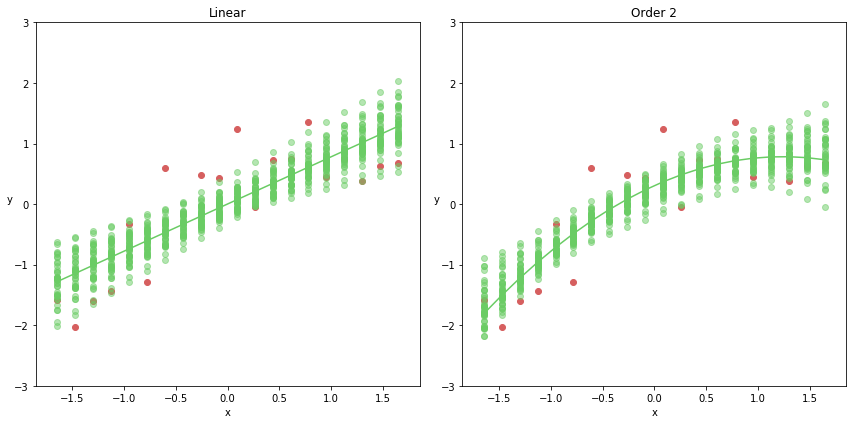

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')


for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='g',
                edgecolors='g', alpha=0.5);
plt.plot(x_1s[0], chain_l['alpha'].mean() + chain_l['beta'].mean()*x_1s[0], c='g', alpha=1)

    
plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Order {}'.format(order))
for i in range(0, len(chain_p['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='g',
                edgecolors='g', alpha=0.5)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], alpha_p_post + np.dot(betas_p_post, x_1s)[idx], c='g', alpha=1);

plt.tight_layout()

# Bayes factors

In [21]:
coins = 30 # 300
heads = 9 # 90
y = np.repeat([0, 1], [coins-heads, heads])
print('These are the coin tosses we are modelling:\n {}'.format(y))

These are the coin tosses we are modelling:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


In [22]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    # model_index is a stochastic variable governed by the Categorical distribution
    # returning 0 or 1 for each model respectively
    model_index = pm.Categorical('model_index', p=p)
    # there are two models with different priors
    # one alpha=4,beta=8 and another alpha=8,beta=4
    m_0 = (4, 8)
    m_1 = (8, 4)
    # m returns the alpha,betas based on whether model index ==0 
    # or not (`pm.math.eq(model_index, 0)`)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)    
    # prior on theta of the Bernouli
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood, y-> 1 heads, 0 tails
    y_pred = pm.Bernoulli('y', theta, observed=y)
     
    trace_BF = pm.sample(5000,chains=1,njobs=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [theta]
100%|██████████| 5500/5500 [00:03<00:00, 1774.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


# $BayesFactor=\frac{p(y|M_{0})}{p(y|M_{1})}=\frac{p(M_{0}|y) \times p(M_{1})}{p(M_{1}|y) \times p(M_{0})}$

Prior of selecting model 0 = 0.50
Prior of selecting model 1 = 0.50
Posterior mean of selecting model 0 = 0.08
Posterior mean of selecting model 1 = 0.92
Bayes factor = 11.43, thus model 0 is more likely


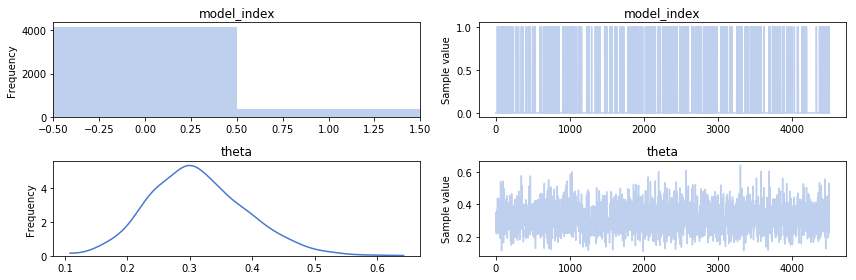

In [23]:
chain_BF = trace_BF[500:]
pm.traceplot(chain_BF)
pM1 = chain_BF['model_index'].mean()
pM0 = 1 - pM1
print('Prior of selecting model 0 = {:.2f}'.format(p[0]))
print('Prior of selecting model 1 = {:.2f}'.format(p[1]))
print('Posterior mean of selecting model 0 = {:.2f}'.format(pM1))
print('Posterior mean of selecting model 1 = {:.2f}'.format(pM0))
print('Bayes factor = {:.2f}, thus model 0 is more likely'.format((pM0/pM1)*(p[1]/p[0])))

### Also model 0 $\alpha=4, \beta=8$ is more compatible with the observations of mostly tails and $\theta<0.5$

## Comparison of models using Information Criteria

In [24]:
with pm.Model() as model_BF_0:
    theta = pm.Beta('theta', 4, 8)
    y_pred = pm.Bernoulli('y', theta, observed=y)
    
    trace_BF_0 = pm.sample(5000,chains=1,njobs=1)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:02<00:00, 2580.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


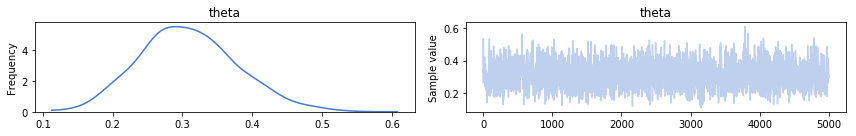

In [25]:
chain_BF_0 = trace_BF_0[500:]
pm.traceplot(trace_BF_0);

In [26]:
with pm.Model() as model_BF_1:
    theta = pm.Beta('theta', 8, 4)
    y_pred = pm.Bernoulli('y', theta, observed=y)
    
    trace_BF_1 = pm.sample(5000,chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:02<00:00, 2729.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


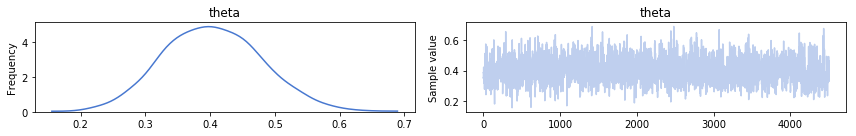

In [27]:
chain_BF_1 = trace_BF_1[500:]
pm.traceplot(chain_BF_1);

In [28]:
waic_0 = pm.waic(chain_BF_0, model_BF_0)
waic_0

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


WAIC_r(WAIC=38.09485595294723, WAIC_se=4.250210218039174, p_WAIC=0.7153551590167374, var_warn=0)

In [29]:
waic_1 = pm.waic(chain_BF_1, model_BF_1)
waic_1

WAIC_r(WAIC=39.45664158585026, WAIC_se=2.0465734755680027, p_WAIC=0.6998503578974625, var_warn=0)

In [30]:
loo_0 = pm.loo(chain_BF_0, model_BF_0)
loo_0

LOO_r(LOO=38.096185450169244, LOO_se=4.250485469459661, p_LOO=0.7160199076277465, shape_warn=0)

In [31]:
loo_1 = pm.loo(chain_BF_1, model_BF_1)
loo_1

LOO_r(LOO=39.45818767404322, LOO_se=2.0467180085626864, p_LOO=0.7006234019939441, shape_warn=0)

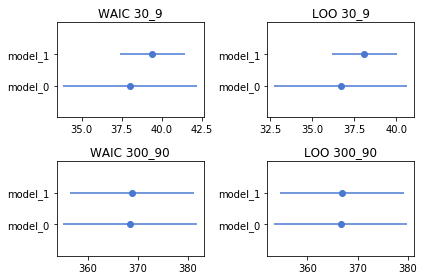

In [32]:
est = [((38.02, 4.17), (39.41, 2.04)), ((36.69, 3.96), (38.09, 1.94)),
       ((368.41, 13.40), (368.76, 12.48)) , ((366.61, 13.31), (366.87, 12.34))]

title = ['WAIC 30_9', 'LOO 30_9', 'WAIC 300_90', 'LOO 300_90']

for i in range(4):
    plt.subplot(2,2,i+1)
    for idx, ic in enumerate(est[i]):
        plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
    plt.title(title[i])
    plt.yticks([0, 1], ['model_0', 'model_1'])
    plt.ylim(-1, 2)

plt.tight_layout()

### Bayes factors are sensitive to the selection of priors and this selection becomes less relevant as we increase the data. As you can see from using the Information Criteria there isn't much of a difference between the models, and these differences are going to become less and less as we increase the number of data. This sensitivity of Bayes factors to the selection of priors makes people not want to use them as much.

In [33]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
